# Imports

In [59]:
# Importing libraries

import re
import sys
import matplotlib.pyplot as plt

import pandas as pd
import plotly.express as px
import yaml
from git_root import git_root
from transformers import AutoTokenizer

In [60]:
# adding git_root and local imports
my_git_root = git_root()
sys.path.append(my_git_root)

from src import flatten, contains_text, extract_table

In [61]:
# importing data
df_documents_path = f'{my_git_root}/data/documents_cleaned.csv'
df_documents = pd.read_csv(df_documents_path)

In [62]:
# importing settings
with open(f'{my_git_root}/settings.yaml', 'r') as file:
    settings = yaml.safe_load(file)

print(settings)

sentence_transformer_model_name = settings['sentence_transformer_model_name']
sentence_transformer_max_tokens = settings['sentence_transformer_max_tokens']

{'sentence_transformer_model_name': 'thenlper/gte-small', 'sentence_transformer_max_tokens': 512, 'llm_model_name': 'tiiuae/Falcon3-7B-Instruct'}


In [63]:
# initializing tokenizer
tokenizer = AutoTokenizer.from_pretrained(sentence_transformer_model_name)

# What does our current data look like?

In [64]:
# Calculate the number of tokens for each document
num_tokens = []

for text in df_documents['text'].to_list():
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))
df_documents['num_tokens'] = num_tokens

In [65]:
df_documents

,name,text,num_tokens
0,aalto-university.md,# Aalto University Research Data Management Po...,1476
1,aberystwyth-university.md,# Research Data Management Policy \n\nVersion...,1003
2,aston-university.md,# Research Data Management Policy \n\nJuly 20...,3131
3,bangor-university.md,# Data Protection Policy \n\n<html><body><tab...,6125
4,brunel-university-london.md,# runel University Research Data Management Po...,2244
...,...,...,...
137,universität-rostock.md,# Research Data Policy of the University of Ro...,1226
138,universität-siegen.md,# Research-Data-Policy of the University of Si...,349
139,universität-stuttgart.md,# Research data management policy of the Unive...,527
140,utrecht-university.md,# University policy framework for research dat...,2225


In [66]:
# histogram: number of tokens for each document
px.histogram(df_documents, x='num_tokens', nbins=100)

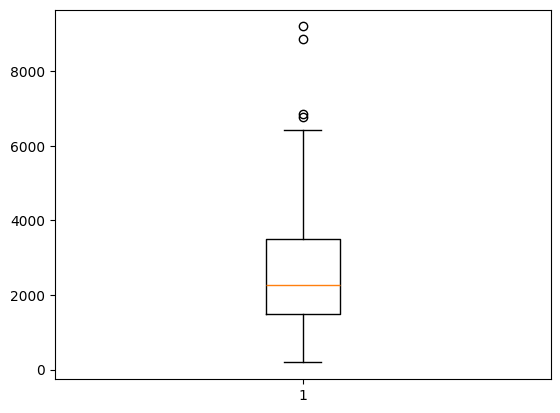

In [67]:
_ = plt.boxplot(df_documents['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/boxplot_original_tokens.svg')

# Chunking documents

## Step 1: Split Documents based on the detected headings

In [68]:
# Split the documents whenever one or more headings symbols # are detected
# Store the number of splits per document
names = []
documents_split = []

for index, row in df_documents.iterrows():
    document_split = re.split(r'\s*#+\s*', row['text'])
    names.append([row['name']] * len(document_split))
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [69]:
# Calculate the number of tokens after splitting
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [70]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [71]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [72]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1644,university-of-strathclyde.md,4. Operational requirements \n\nThe following...,3167
769,robert-gordon-university.md,RESEARCHDATAMANAGEMENT \n\n1. Purpose and Con...,2402
1131,university-medical-center-utrecht.md,3.7.2. Trusted Third Party (TTP) \n\nFor link...,2069
153,de-montfort-university.md,SCOPE \n\n3. This policy applies to all DMU s...,1945
1646,university-of-strathclyde.md,Appendix A – Glossary of Terms \n\n<html><bod...,1912
...,...,...,...
1557,university-of-potsdam.md,Contents,1
1453,university-of-hull.md,Responsibilities,1
1370,university-of-helsinki.md,Contents,1
830,technical-university-delft.md,Introduction,1


In [73]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/1_token_hist_headings.pdf')

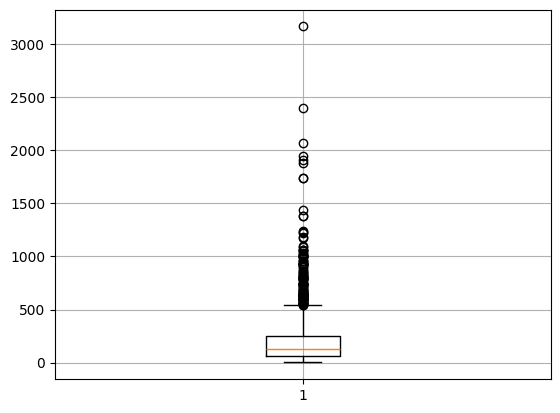

In [74]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.grid()
plt.savefig(f'{my_git_root}/notebooks/images/1_token_boxplot_headings.svg')

**After this point, we ONLY split if the chunks exceed the given sentence_transformer_max_tokens!!**

## Step 2: Split by Section Numbering (First Order)

In [75]:
# Split the documents whenever a numbering '\n1.', '\n2.', '\n3.' is detected right after a linebreak
# We only consider linebreaks of the first order, so we do not consider '\n1.1.', '\n1.2.', '\n1.3.'
# Store the number of splits per document
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\n\d+\.\s*(?!\d+\.?)\s*', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [76]:
# Calculate the number of tokens after splitting
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [77]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [78]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [79]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1931,university-of-strathclyde.md,4. Operational requirements \n\nThe following...,3167
1339,university-medical-center-utrecht.md,Abbreviations and definitions \n\n\n<html><b...,2019
1933,university-of-strathclyde.md,Appendix A – Glossary of Terms \n\n<html><bod...,1912
1482,university-of-copenhagen.md,Appendix 1: Definitions \n\n<html><body><tabl...,1885
1882,university-of-reading.md,7.0 Contact \n\na. Queries regarding research...,1742
...,...,...,...
1111,the-open-university.md,Policy,1
1401,university-of-bradford.md,Policy,1
1421,university-of-cambridge.md,Background \n,1
1708,university-of-hull.md,Responsibilities,1


In [80]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/2_token_hist_sections_1.pdf')

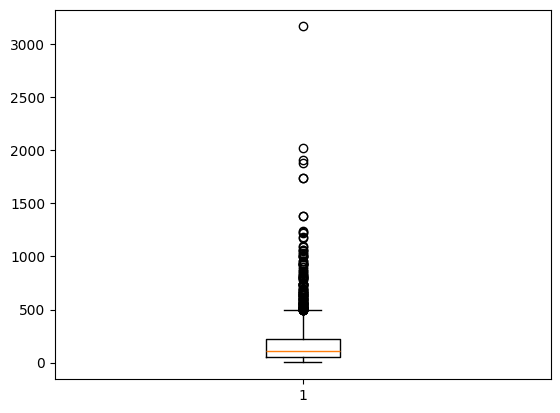

In [81]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/2_token_boxplot_sections_1.svg')

## Step 3: Split by Section Numbering (Second Order)

In [82]:
# Split the documents whenever a second-order numbering '\n1.1', '\n2.1.', '\n3.4' is detected right after a linebreak
# Store the number of splits per document

names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\n(?<!\d\.)\d+\.\s*\d+\.?\s+', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [83]:
# Calculate the number of tokens after splitting
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [84]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [85]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [86]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1433,university-medical-center-utrecht.md,Abbreviations and definitions \n\n\n<html><b...,2019
2104,university-of-strathclyde.md,Appendix A – Glossary of Terms \n\n<html><bod...,1912
1576,university-of-copenhagen.md,Appendix 1: Definitions \n\n<html><body><tabl...,1885
2054,university-of-salford.md,7.0 Contact \n\na. Queries regarding research...,1742
2029,university-of-reading.md,7.0 Contact \n\na. Queries regarding research...,1742
...,...,...,...
601,iscte---instituto-universitario-de-lisboa.md,Introduction,1
1981,university-of-potsdam.md,Contents,1
520,heriot-watt-university.md,Section,1
1515,university-of-cambridge.md,Background \n,1


In [87]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/3_token_hist_sections_2.pdf')

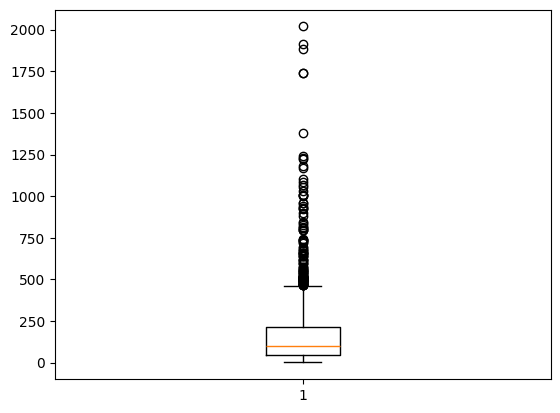

In [88]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/3_token_boxplot_sections_2.svg')

## Step 4: Split by paragraphs

In [89]:
# Split the documents by paragraphs '\n\n'
# Store the number of splits per document
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\s*\n\s*\n\s*', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [90]:
# Calculate the number of tokens
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [91]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [92]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [93]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
2568,university-of-salford.md,"<html><body><table><tr><td colspan=""5"">Documen...",1689
2537,university-of-reading.md,"<html><body><table><tr><td colspan=""5"">Documen...",1689
1811,university-medical-center-utrecht.md,<html><body><table><tr><td>Human research</td>...,1036
1265,robert-gordon-university.md,<html><body><table><tr><td></td><td>Institutio...,917
1810,university-medical-center-utrecht.md,<html><body><table><tr><td>Term</td><td>Defini...,862
...,...,...,...
1524,the-university-of-edinburgh.md,References,1
653,heriot-watt-university.md,C,1
655,heriot-watt-university.md,Section,1
2483,university-of-potsdam.md,Contents,1


In [94]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/4_token_hist_paragraphs.pdf')

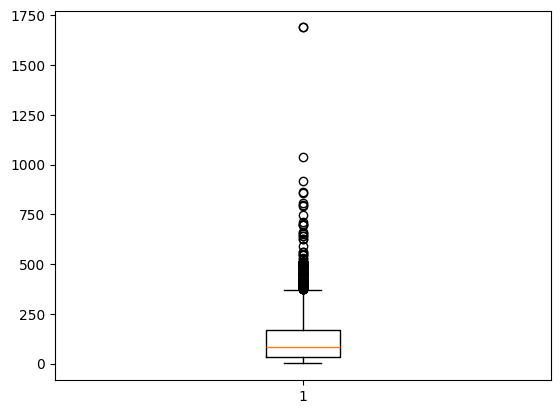

In [95]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/4_token_boxplot_paragraphs.svg')

## Step 5: Extract table data

In [96]:
# Extract the data from the table into plain text
documents_split = df_documents_split['text'].apply(extract_table).to_list()
df_documents_split['text'] = documents_split

In [97]:
# Calculate the number of tokens
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [98]:
# Add to dataframe
df_documents_split['num_tokens'] = num_tokens

In [99]:
#What does our data look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
742,international-institute-for-geo---information-...,• All research activities involving personal d...,858
1265,robert-gordon-university.md,InstitutionSchoolAcademicGuidanceDocumentation...,629
1811,university-medical-center-utrecht.md,Human researchAllscientificresearchinwhichpeop...,626
1894,university-of-bradford.md,"5.2.1 Researchers must comply with all legal,...",591
1752,university-campus-suffolk.md,a. The Data Subject has given explicit consent...,524
...,...,...,...
2291,university-of-hull.md,Responsibilities,1
2483,university-of-potsdam.md,Contents,1
2190,university-of-helsinki.md,Contents,1
1330,staffordshire-university.md,Policy \n,1


In [100]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images//5_token_hist_tables.pdf')

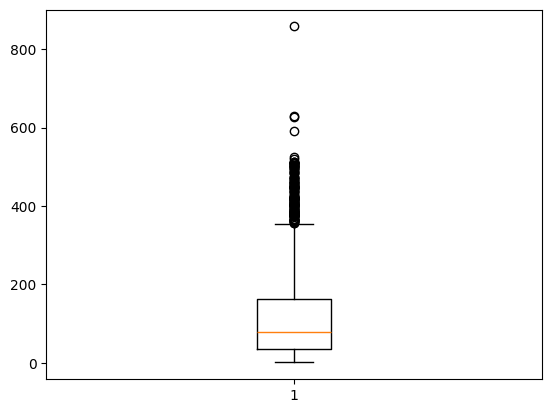

In [101]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/5_token_boxplot_tables.svg')

## Step 6: Split newlines

In [102]:
# If any chunk is still too long, we split it by its newline symbols '\n'
# Split the documents by list items while keeping track of the names
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\n+', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional

names = flatten(names)
documents_split = flatten(documents_split)

In [103]:
# Calculate the number of tokens

num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [104]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [105]:
# What does our data look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1279,robert-gordon-university.md,InstitutionSchoolAcademicGuidanceDocumentation...,629
1834,university-medical-center-utrecht.md,Human researchAllscientificresearchinwhichpeop...,626
1006,medizinische-universität-graz.md,TermAbbreviationMeaningThirdA natural or legal...,520
1833,university-medical-center-utrecht.md,TermDefinitieAnonymiseThe removal of directly ...,513
1608,the-university-of-northampton.md,4.2 Research data management procedure \n\nAt...,512
...,...,...,...
2325,university-of-hull.md,Responsibilities,1
1840,university-medical-center-utrecht.md,TotstandkomingengoedkeuringDatumBeheerderResea...,1
1905,university-of-bradford.md,Policy,1
484,faculty-of-humanities-of-utrecht-university.md,Regulations,1


In [106]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/6_token_hist_newlines.pdf')

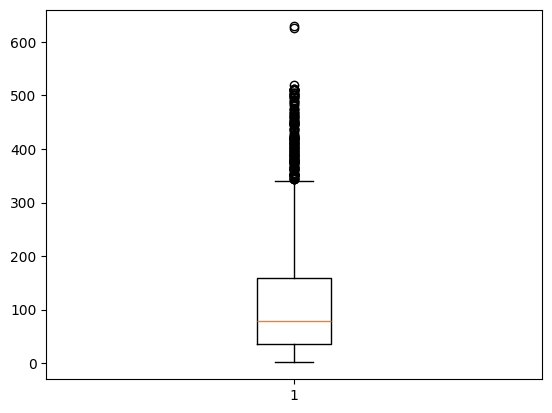

In [107]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/6_token_boxplot_newlines.svg')


## Step 7: Split chunks into halves

In [108]:
# For all the remaining chunks, we will simply cut them in half
# Split the documents by paragraphs while keeping track of the names
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        text = row['text']
        document_split = [text[:len(text)//2], text[len(text)//2:]]
        names.append([row['name']] * 2)
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional

names = flatten(names)
documents_split = flatten(documents_split)

In [109]:
# Calculate the number of tokens

num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [110]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [111]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [112]:
# What does our data look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1244,research-data-management-policy.md,4.2 Research data management procedure \n\nAt...,512
1610,the-university-of-northampton.md,4.2 Research data management procedure \n\nAt...,512
1343,sorbonne-university.md,Recommendations for the opening of research da...,511
1027,medizinische-universität-wien.md,TermAbbreviationMeaningDataClearingHouseBefore...,511
897,leiden-university.md,B. Responsibilities \n\n10. The Faculty Board...,511
...,...,...,...
108,brunel-university-london.md,Policy,1
1561,the-university-of-exeter.md,Context,1
1201,qutech.md,Preface,1
1409,technical-university-of-darmstadt.md,Guidelines \n,1


In [113]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/7_token_hist_halves.pdf')

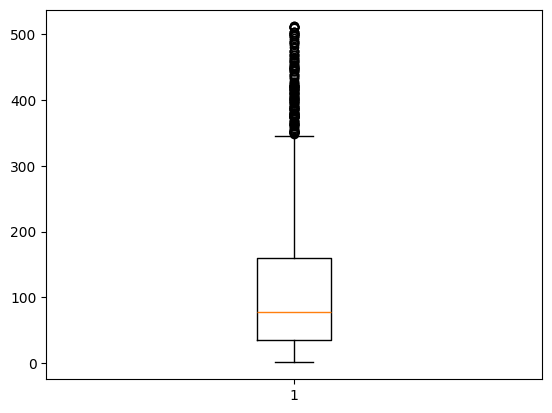

In [114]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/7_token_boxplot_halves.svg')

# Export chunked dataset

In [115]:
# df_documents_split.to_csv(f'{my_git_root}/data/documents_chunked.csv', index=False)